# Deep Neural Network Recommender System
In this Notebook, we will build another music recommendation system. This time, we will incorporate a deep learning approach as explained in the introduction. We will be using Keras on Tensorflow V2 for this model. Keras is a high-level API built on-top of Tensorflow. It offers a range of utilities for getting started with recommender systems which we will use throughout this Notebook.

In [1]:
import os
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import tensorflow_recommenders as tfrs
import tensorflow_datasets as tfds

## Data Preprocessing
Here we just repeat some data preprocessing steps as previous. However, we will incorporate a new way to normalise our weight values. In the previous notebook, the normalised weight values lead to poor performance of the model. Because of this, we opted to use a binary model. However, in this notebook we will normalise the weight column on a per user basis. This will be discussed shortly.

In [153]:
#Let's define our amount of users
rating_matrix = pd.read_csv('../data/user_artists.dat', sep='\t', encoding='latin-1')
num_users = len(rating_matrix.userID.unique())

#Extract userID column
userids = np.asarray(rating_matrix.userID)

#Remap the column
u_mapper, u_ind = np.unique(userids, return_inverse=True)

In [154]:
#Let's define our amount of artists
artists = pd.read_csv('../data/artists.dat', sep='\t', encoding='latin-1')
artists.rename(columns={'id':'artistID'}, inplace=True)
num_artists = len(artists.artistID.unique())

#Extract artistID column
artistids = np.asarray(rating_matrix.artistID)

#Remap the column
a_mapper, a_ind = np.unique(artistids, return_inverse=True)

In [155]:
# Let's replace old columns with new ind ones
rating_matrix.userID = u_ind
rating_matrix.artistID = a_ind

#Let's ensure the max value is approriate
assert(rating_matrix.userID.unique().max() == 1891)
assert(rating_matrix.artistID.unique().max() == 17631)

In [156]:
#We convert the ID's to string so we can use the StringLookup function later
rating_matrix.userID = rating_matrix.userID.apply(str)
rating_matrix.artistID = rating_matrix.artistID.apply(str)

## Normalising the 'weight' Column
Rather than normalising the entire weight column as one array, we can normalise the values for each user individually. Simply put, the artist that a particular user listens to the most will have a high value such as 1. The artist they listen to the least will be closer to 0.

This is a better representation of a user's preferences than normalising the entire weight column, which can lead to very insignificant values. Normalising the entire weight column will lead to user-artist pairs having small values for weight solely because other users have listened to more music in general.

In the following function, we create a new rating matrix which is populated by each users ratings one at a time. Once this is complete, we replace our old `rating_matrix` variable with `new_rating_matrix` to keep continuity of naming conventions.

In [169]:
#Let's normalise our weight column
new_rating_matrix = pd.DataFrame(columns=['userID', 'artistID', 'weight'])
for user_id in rating_matrix.userID.unique():
    user_ratings = rating_matrix[rating_matrix.userID == user_id]
    ratings = np.array(user_ratings['weight'])
    user_ratings['weight'] = tf.keras.utils.normalize(ratings, axis=-1, order=2)[0]
    new_rating_matrix = new_rating_matrix.append(user_ratings)
rating_matrix = new_rating_matrix
rating_matrix.describe()

C:\Users\seanc\AppData\Local\Temp/ipykernel_5620/4251931852.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_ratings['weight'] = tf.keras.utils.normalize(ratings, axis=-1, order=2)[0]


,weight
count,92834.000000
mean,0.091235
std,0.109804
min,0.000008
25%,0.030397
50%,0.062543
75%,0.109109
max,1.000000


## Create DataSet
In the following cells, we will be creating a tensor DataSet using the `from_tensor_slices()` function. We must firstly create our `interactions_dict`, which is just our rating_matrix in dictionary form.

In [170]:
## we tansform the table inta a dictionary , which then we feed into tensor slices
# this step is crucial as this will be the type of data fed into the embedding layers
interactions_dict = {name: np.array(value) for name, value in rating_matrix.items()}
interactions = tf.data.Dataset.from_tensor_slices(interactions_dict)

## we do similar step for item, where this is the reference table for items to be recommended
items_dict = rating_matrix[['artistID']].drop_duplicates()
items_dict = {name: np.array(value) for name, value in items_dict.items()}
items = tf.data.Dataset.from_tensor_slices(items_dict)

## map the features in interactions and items to an identifier that we will use throught the embedding layers
## do it for all the items in interaction and item table
## you may often get itemtype error, so that is why here i am casting the quantity type as float to ensure consistency
interactions = interactions.map(lambda x: {'userID' : x['userID'], 
                                            'artistID' : x['artistID'], 
                                            'weight' : x['weight']})

items = items.map(lambda x: x['artistID'])

We must also create variables representing our unique user ID's and artist ID's.

This will allow us to map the raw values of our categorical features to embeddings vectors in our models. For this, we need a vocabulary mapping raw feature values to an integfer in a contiguous range. This allows us to look up the corresponding embeddings in our tables.

In [171]:
### get unique item and user id's as a lookup table
unique_artist_ids = (np.unique(a_ind)).astype(str)
unique_user_ids = (np.unique(u_ind)).astype(str)

# Randomly shuffle data and split between train and test.
tf.random.set_seed(42)
shuffled = interactions.shuffle(100_000, seed=42, reshuffle_each_iteration=False)
train = shuffled.take(62_000)
test = shuffled.skip(62_000).take(30_000)

In [172]:
print(f'our test set is: {len(train)}')
print(f'our train set is: {len(test)}')

our test set is: 62000
our train set is: 30000


## Simple Retrieval Model
In the following cells, we define a simple retrieval model. Although defined differently, this model works on the same principals as our previous matrix factorisation model. We just include this step as a progression towards a more advanced deep learning model.

The TFRS package with Keras makes development of recommender systems simple and intuitive. We simply inherit from the base `tfrs.Model` class, define our query (user) and item (artist) towers or embeddings, then define our loss function and metrics to be used and our model is ready to deploy.

In [136]:
#Basic retrieval model
    def __init__(self, user_model, item_model):
        super().__init__()

        ### we pass the embedding layer into item model
        self.item_model: tf.keras.Model = item_model
            
        ### We pass the embedding layer into user model
        self.user_model: tf.keras.Model = user_model
        
        ### for retrieval model. we take top-k accuracy as metrics
        metrics = tfrs.metrics.FactorizedTopK(candidates=items.batch(128).map(item_model))
        
        # define the task, which is retrieval                                        
        task = tfrs.tasks.Retrieval(metrics=metrics)
        self.task: tf.keras.layers.Layer = task

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        # We pick out the user features and pass them into the user model.
        user_embeddings = self.user_model(features["userID"])
        # And pick out the item features and pass them into the item model,
        # getting embeddings back.
        positive_item_embeddings = self.item_model(features["artistID"])

        # The task computes the loss and the metrics.
        return self.task(user_embeddings, positive_item_embeddings)

## Train and Evaluate Model
The following cell is used to train and evaluate our model. We firstly define the size of our embedding dimensions. Then, we build our user and item embedding vectors using `tf.keras.layers.Embedding`. In this function, we add an additional embedding layer to account for unknown tokens (if any).

We simply instantiate our model and compile it with an optimisation function of our choice. We will use Adagrad in this instance. We then fit the model on our training data and provide our number of epochs. Following from this, we fit the data on our test set.

Epoch 1/10
7/7 [==============================] - 54s 7s/step - factorized_top_k/top_1_categorical_accuracy: 0.0016 - factorized_top_k/top_5_categorical_accuracy: 0.0114 - factorized_top_k/top_10_categorical_accuracy: 0.0237 - factorized_top_k/top_50_categorical_accuracy: 0.0783 - factorized_top_k/top_100_categorical_accuracy: 0.1086 - loss: 72704.5215 - regularization_loss: 0.0000e+00 - total_loss: 72704.5215  
Epoch 2/10
7/7 [==============================] - 57s 8s/step - factorized_top_k/top_1_categorical_accuracy: 0.0080 - factorized_top_k/top_5_categorical_accuracy: 0.0430 - factorized_top_k/top_10_categorical_accuracy: 0.0805 - factorized_top_k/top_50_categorical_accuracy: 0.2462 - factorized_top_k/top_100_categorical_accuracy: 0.3486 - loss: 69661.6450 - regularization_loss: 0.0000e+00 - total_loss: 69661.6450
Epoch 3/10
7/7 [==============================] - 58s 8s/step - factorized_top_k/top_1_categorical_accuracy: 0.0091 - factorized_top_k/top_5_categorical_accuracy: 0.0512 

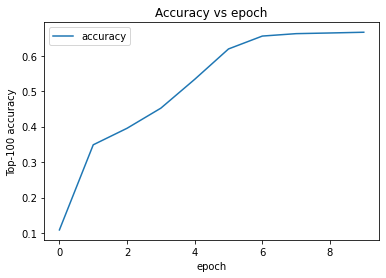

In [137]:
### Fitting and evaluating
### we choose the dimensionality of the query and candicate representation.
embedding_dimension = 32
## we pass the model, which is the same model we created in the query and candidate tower, into the model
user_model = tf.keras.Sequential(
    [tf.keras.layers.experimental.preprocessing.StringLookup(
                                vocabulary=unique_user_ids, mask_token=None),
                                # We add an additional embedding to account for unknown tokens.
                                tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)])

item_model = tf.keras.Sequential(
    [tf.keras.layers.experimental.preprocessing.StringLookup(
                                vocabulary=unique_artist_ids, mask_token=None),
                                tf.keras.layers.Embedding(len(unique_artist_ids) + 1, embedding_dimension)])

model = MusicModel(user_model, item_model)

# a smaller learning rate may make the model move slower and prone to overfitting, so we stick to 0.1
# other optimizers, such as SGD and Adam, are listed here https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))
cached_train = train.shuffle(100_000).batch(10_000).cache()
cached_test = test.batch(10_000).cache()

## fit the model with ten epochs
model_hist = model.fit(cached_train, epochs=10)

#evaluate the model
model.evaluate(cached_test, return_dict=True)

# num_validation_runs = len(one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [i for i in range(10)]

plt.plot(epochs, model_hist.history["factorized_top_k/top_100_categorical_accuracy"], label="accuracy")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

## Simple Retrieval Model Analysis
The above model trains for 10 epoch and is then evaluated on testing data. In the training epoch information, we see information such as `top_5_categorical_accuracy`. This is indicative of the models ability to return a true-positive in the top-5 retrieved items (artists) from the entire set. We see that for each epoch, the model generally gets better at returning true-positives.

In the evaluation information, we see these accuracies drop significantly. This signifies that are model is overfitting to our training data. We can introduce regularisation terms as previous to mitigate this effect. Also, in deep learning models, we may introduce more user and artist features that help the model generalise better.

In [138]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends item out of the entire items dataset.
index.index_from_dataset(
    tf.data.Dataset.zip(items.batch(100).map(model.item_model)))

# Get recommendations.
j = str(10)
_, titles = index(tf.constant([j]))

arr = np.array(titles)[0]
names = []

for artist_id in arr:
    names.append(artists[artists['artistID'] == int(artist_id)]['name'])
names = np.asarray(names)
print(f"Recommendations for user %s: {names}" %(j))

Recommendations for user 10: [['Savage Garden']
 ['Ke$ha']
 ['Library Tapes']
 ['nevershoutnever!']
 ['Poney Express']
 ['Ra Ra Riot']
 ['The Rakes']
 ['Astrud Gilberto']
 ['Bon Iver']
 ['Metro Station']]


## Ranking Model
In the following cells, we will upgrade from our previous model by using a ranking model. In this model, we will be making use of `dense` keras layers with 'RELU' activation functions. This is a deep learning approach. We will also be attempting to make use of the explicit rating values in the `weight` column of our rating matrix. 

Moderm recommender systems usually operate in two stages:
* Retrieval
* Ranking

We will firstly define our `RankingModel` class which will act as our ranking model. Our `MusicModel` will act as the retrieval model as previous.

In [173]:
#Define our ranking model
class RankingModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        embedding_dimension = 32

        ### we pass the embedding layer into item model
        self.item_model: tf.keras.Model = item_model
            
        ### We pass the embedding layer into user model
        self.user_model: tf.keras.Model = user_model

        # Compute predictions.
        self.ratings = tf.keras.Sequential([
                      # Learn multiple dense layers.
                      tf.keras.layers.Dense(256, activation="relu"),
                      tf.keras.layers.Dense(64, activation="relu"),
                      # Make rating predictions in the final layer.
                      tf.keras.layers.Dense(1)])

    def call(self, inputs):
        user_id, item_title = inputs
        user_embedding = self.user_model(user_id)
        item_embedding = self.item_model(item_title)
        return self.ratings(tf.concat([user_embedding, item_embedding], axis=1))

In [174]:
#Now our base retrieval model incorporates our ranking model
class MusicModel(tfrs.models.Model):

    def __init__(self):
        super().__init__()
        self.ranking_model: tf.keras.Model = RankingModel()
            
        #Let's define our Loss function and optimisation function
        self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
                          loss = tf.keras.losses.MeanSquaredError(),
                          metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
        return self.ranking_model(
            (features["userID"], features["artistID"]))

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        rating_predictions = self.ranking_model(
            (features["userID"], features["artistID"]))

        # The task computes the loss and the metrics.
        return self.task(labels=features["weight"], predictions=rating_predictions)

**Note**: This model differs to our previous retrieval model as we are now incorporating the weight column, whereas our previous model worked solely on binary values. This Deep Learning Framework is more robust and can handle the disparity between values in our weight column. We normalised our weight column values earlier. This is an important preprocessing step to achieve good model performance.

In [175]:
### Fitting and evaluating
### we choose the dimensionality of the query and candicate representation.
embedding_dimension = 32
## we pass the model, which is the same model we created in the query and candidate tower, into the model
user_model = tf.keras.Sequential(
    [tf.keras.layers.experimental.preprocessing.StringLookup(
                                vocabulary=unique_user_ids, mask_token=None),
                                # We add an additional embedding to account for unknown tokens.
                                tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)])

item_model = tf.keras.Sequential(
    [tf.keras.layers.experimental.preprocessing.StringLookup(
                                vocabulary=unique_artist_ids, mask_token=None),
                                tf.keras.layers.Embedding(len(unique_artist_ids) + 1, embedding_dimension)])

model = MusicModel()

# a smaller learning rate may make the model move slower and prone to overfitting, so we stick to 0.1
# other optimizers, such as SGD and Adam, are listed here https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))
cached_train = train.shuffle(100_000).batch(10_000).cache()
cached_test = test.batch(10_000).cache()

## fit the model with ten epochs
model_hist = model.fit(cached_train, epochs=10)

#evaluate the model
model.evaluate(cached_test, return_dict=True)

Epoch 1/10
7/7 [==============================] - 2s 78ms/step - root_mean_squared_error: 0.1133 - loss: 0.0129 - regularization_loss: 0.0000e+00 - total_loss: 0.0129
Epoch 2/10
7/7 [==============================] - 0s 48ms/step - root_mean_squared_error: 0.1097 - loss: 0.0123 - regularization_loss: 0.0000e+00 - total_loss: 0.0123
Epoch 3/10
7/7 [==============================] - 0s 48ms/step - root_mean_squared_error: 0.1096 - loss: 0.0123 - regularization_loss: 0.0000e+00 - total_loss: 0.0123
Epoch 4/10
7/7 [==============================] - 0s 44ms/step - root_mean_squared_error: 0.1095 - loss: 0.0123 - regularization_loss: 0.0000e+00 - total_loss: 0.0123
Epoch 5/10
7/7 [==============================] - 0s 48ms/step - root_mean_squared_error: 0.1095 - loss: 0.0123 - regularization_loss: 0.0000e+00 - total_loss: 0.0123
Epoch 6/10
7/7 [==============================] - 0s 50ms/step - root_mean_squared_error: 0.1094 - loss: 0.0122 - regularization_loss: 0.0000e+00 - total_loss: 0.012

{'root_mean_squared_error': 0.11132322996854782,
 'loss': 0.011565779335796833,
 'regularization_loss': 0,
 'total_loss': 0.011565779335796833}

## Ranking Model Performance Analysis
We allowed our model to train for a total of 10 epochs before being evaluated on unseen testing data. Using RMSE as our objective function, we see this model is able to achieve great performance. The performance of our model does not drop significantly for unseen data.

Using RMSE as our metric allows us to quantitately compare the performance of this model with our previous matrix factorisation approach. In matrix factorisation, we achieved: 
* `'train_error': 0.15067895, 'test_error': 0.23825963` for our unregularised model. 
* `'train_error': 0.29663688, 'test_error': 0.32661134` for our regularised model.

We noted that the increase in error for our regularised model leads to better generalisations. In this deep learning model, we achieved:
* `'train_error': 0.1093, 'test_error': 0.1113`.

---
## Qualitative Performance Analysis
Although the quantitative analysis of this model seems good, we do not know whether this leads to good recommendations or not. Let's perform a qualitative analysis of the model. We'll do the following:
* Take a typical user with a reasonable amount of artists they listen to
* Sample 5 random artists they listen to
* Along with the user id, provide the artist id's selected to our model
* We expect our model to return a ranking of these artist ID's in the order that the user is most interested in them.

In [192]:
#User 100
user_0 = rating_matrix[rating_matrix['userID'] == "100"]

#Sample 5 artists they listen to
user_0_sample = user_0.sample(5, random_state=74)
user_0_sample

,userID,artistID,weight
4986,100,2649,0.205387
4980,100,2146,0.164745
4990,100,2653,0.150230
4972,100,769,0.137167
4996,100,2659,0.083461


The following cell takes in artist ID's and a userID and computes a score for their combination. The model returns the artists in order of the scores they achieve. We expect this order to be similar to the order shown in the above sample.

In [206]:
test_ratings = {}
test_artist_ids = np.array(["2649", "2146", "2653", "769", "2659"])
for artistid in test_artist_ids:
    test_ratings[artistid] = model({
        "userID": np.array(["100"]),
        "artistID": np.array([artistid])
    })

print("Ratings:")
for artist, score in sorted(test_ratings.items(), key=lambda x: x[1], reverse=True):
    print(f"{artist}: {score}")

Ratings:
2649: [[0.09791555]]
2653: [[0.09428623]]
2146: [[0.0825875]]
769: [[0.08212695]]
2659: [[0.07627478]]


### Output Analysis
We can see in the above cell that from the 5 sampled artists, our recommender system correctly identified the most liked artist as "2649". The system did rank "2653" in second place, when in reality that artist is the user's third favourite artist. However, the true ratings of the second and third most liked artist for this particular user differ only marginally.

From this small example, we can see that our model performs quite well.

---

## Conclusion
In this notebook, we were able to create a two-part recommender system using Tensorflow V2. Modern recommender systems commonly adopt a two-step approach to making recommendations. The first step involves retrieving items that a particular query (user) will enjoy. The second step involves ranking this items and returning the ranked list to the user.

There exists plenty room to expand our model from here. TensorFlow offers a vast amount of API's for further expansion of recommender systems. In the grand scheme of things, this system is still considered quite trivial despite making strong recommendations. In our next notebook, we will attempt to incorporate some extra features into our recommendation system, such as genre tags as well as timestamps for when these genres were applied.